### Abstract

In this tutorial you will see how to apply nlfem to assemble finite element stiffness matrices of truncated integral operators. The tutorial consists of two parts. In the first part we give an interactive presentation on the basic usage of the code with some notes on how to customize it. In the second part you can try out other examples which have been prepared for the tutorial, or you can explore the package yourself.

The presentation will mainly discuss complex domains, basic settings, and the implications of the choice of kernel functions and truncations for different integration routines.
Nonlocal operators can be defined on complex domains like disjoint sets, which require some special treatment. The basic settings of the assembly routine are given by Python dictionaries, which contain information about the mesh, the ansatz space, quadrature rules, the interaction horizon, the kernel and so on. You will see in the presentation step by step how to set up the basic settings for the assembly of a truncated fractional type operator on a disjoint domain, and finally solve a Dirichlet problem. We also touch on the question how to further customize the implementation e.g. with user defined kernels.

In the second part you can try out more examples yourself. The code can be executed in a jupyter notebook inside of a docker container, which contains all required libraries. Make sure that you are able to run a docker container. Otherwise you can also install all dependencies and compile the code yourself. You find all necessary information for both approaches in the readme file of the repository (https://gitlab.uni-trier.de/klar/nonlocal-assembly/-/tree/master).

In [2]:
%matplotlib inline

import numpy as np
from scipy.sparse.linalg import spsolve
import nlfem
from mesh import trim_artificial_vertex
import plot
from conf import cfg_dict
import os
import matplotlib.pyplot as plt

# Problem
Let $\tilde{\Omega}$ be compact and $\Omega$ be open in $\tilde{\Omega}$. We denote $\Gamma := \tilde{\Omega} \setminus \Omega$.
\begin{align*}
 -\mathcal{L}_\delta u(x) = p.v. 2 \int_{\tilde{\Omega} \cap B_\delta} 
 C(x,y)u(x) - C(y,x)u(y) dy.
\end{align*}
Where it holds that
\begin{align*}
 (v, -\mathcal{L}_\delta u ) = \int_{\tilde{\Omega}} \int_{\tilde{\Omega} ~ \cap B_\delta} 
 \left( v(x) - v(y))(C(x,y)u(x) - C(y,x)u(y) \right) dy ~ dx.
\end{align*}

We seek to solve

\begin{align*}
-\mathcal{L}_\delta &u = f \textrm{ in } \Omega \\
&u = g \textrm{ on } \Gamma \\
\end{align*}

# Build and install

Find eveything on https://gitlab.uni-trier.de/klar/nonlocal-assembly

```bash
python3 setup.py build --force install
```

# Domain

## Elements and element labels
 
 
 - Positive labels belong to $\Omega$
 - Negative labels to $\Gamma$
 - Elements with label 0 are ignored

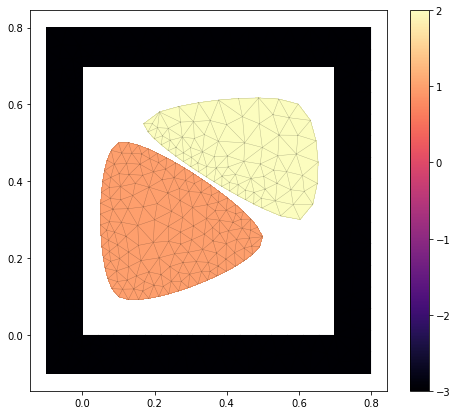

In [4]:
vertices, elements, elementlabels = cfg_dict["disjoint_noav"]["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)
plot.plot_2d_diffusion_elementlabels(mesh)

## Vertex labels

 - Positive labels belong to $\Omega$ (unknowns in case of CG)
 - Negative labels to $\Gamma$ (Dirichlet boundary)
 - Vertices with label 0 are ignored

 > If a set $A$ is closed all vertices $x$ of elements $\mathcal{E} \subset A$ have the same label as $\mathcal{E}$.

 - $\tilde{\Omega} \subset \mathbb{R^2}$ is closed

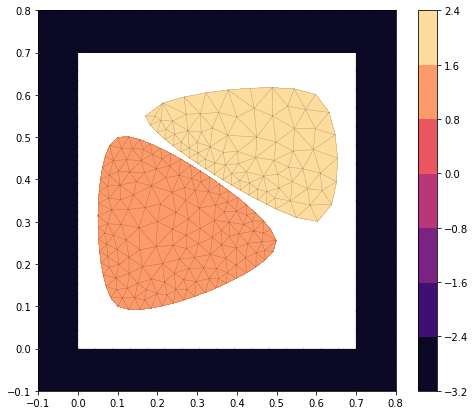

In [3]:
plot.plot_2d_diffusion_vertexlabels(mesh)

 - $\Gamma \subset \tilde{\Omega} $  is closed

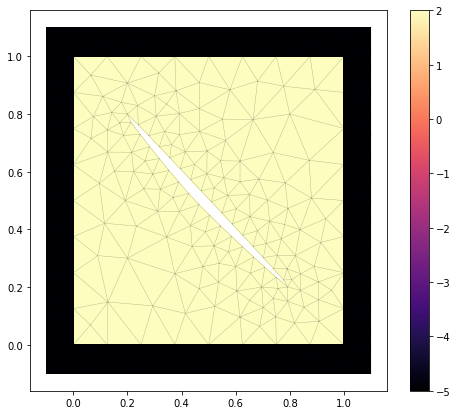

In [4]:
vertices, elements, elementlabels = cfg_dict["hole_noav"]["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)
plot.plot_2d_diffusion_elementlabels(mesh)

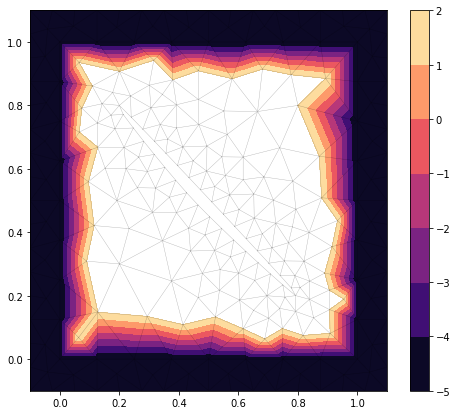

In [5]:
plot.plot_2d_diffusion_vertexlabels(mesh)

We use a breadth first traversal to efficiently find the interacting elements 

\begin{align*}
    \mathcal{E}_b \cap B_\delta(x) \neq \emptyset
\end{align*}
for some $x \in \mathcal{E}_a$.

## Artificial elements

In general $\tilde{\Omega} \cap B_\delta(x)$ is **not connected** for all $x$, and the traversal fails. **Artificial elements** induce a search graph which always connected. 
It is sufficient to add artificial elements at the boundary $\partial \tilde{\Omega}$.

In [6]:
vertices, elements, elementlabels = cfg_dict["hole_av"]["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)

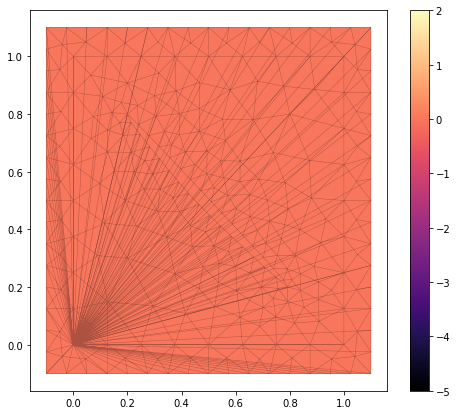

In [7]:
plot.plot_2d_diffusion_elementlabels(mesh)

In [8]:
vertices, elements, elementlabels = cfg_dict["disjoint_av"]["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)

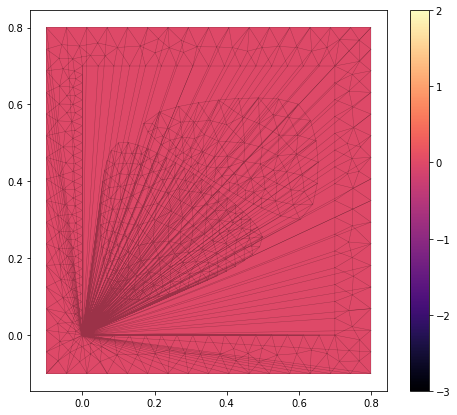

In [9]:
plot.plot_2d_diffusion_elementlabels(mesh)

# Kernel

## Kernel function

The kernel functions $C(x,\ell_x, y, \ell_y)$ have a common interface and depend on the points $x,y$ as well as the element labels $\ell_x, \ell_y$. They can be configured by a dictionary.

We hand over 
 - the kernel function `function`
 - the size of the interaction horizon `horizon`
 - the outputdimension of the kernel `outputdim` (1 for scalar, 2 for matrix-valued)
 - the fractional order `fractional_s` (optional).

In [5]:
kernel = {
            "horizon": 0.3
         }

## Preimplemented kernels

Preimplemented kernel functions are in 2D, i.e. options for `function`, are


| name | kernel function $C(x,y)$ | 
|---|----------------------------|
| "constant"  | $\frac{4}{\pi \delta^4}$ |  
| "constantLinf2D"  | $\frac{3}{4 \delta^{4}}$ |
| "linearPrototypeMicroelastic"  | $\frac{3 }{\pi\delta^{3}}\frac{1 }{  \vert x-y\vert }$ | 
| "linearPrototypeMicroelasticField"  | $\frac{3 }{\delta^{3}}\frac{(x -y) \otimes (x -y)}{  \vert x-y\vert^3 }$ | 
| "fractional"  | $\frac{d - 2s }{\pi\delta^{d-2s}}\frac{1 }{  \vert x-y \vert^{d+2s} }$ | 
| "labeledValve"  | $0$ if $\ell_x < \ell_y$ | 

In [11]:
kernel["function"] = "fractional"
kernel["outputdim"] = 1
kernel["fractional_s"] = 0.5

## Self defined kernels

You can define kernel functions yourself. The code has to be recompiled to use them.

Declare your kernel by adding to *src/models.h*

```C++
void kernel_myKernel(const double * x, const long labelx, 
                            const double * y, const long labely, 
                            const MeshType &mesh,
                            double * kernel_val)  
```

Implement your kernel by adding to *src/models.cpp*

```C++
void kernel_myKernel(const double * x, const long labelx, 
                            const double * y, const long labely, 
                            const MeshType &mesh,
                            double * kernel_val)
{
    // Code with output to &kernel_val
}
```

Make your kernel available by adding this to *src/Cassemble.cpp* 

```C++
map<string, void (*)(const double * x, long labelx, const double * y, long labely,
                     const MeshType &mesh, double * kernel_val)> lookup_kernel = {
                             
        {"mykernelname", kernel_myKernel},
        //  other preimplemented kernels....
}
```

Build and install the code...

All other configurations happen in a Python dictionary `conf` which we set up now.

In [12]:
conf = {}

#  Integration routines

\begin{align*}
 (v, -\mathcal{L}_\delta u) = \int_{\mathcal{E}_a} \int_{\mathcal{E}_b ~ \cap B_\delta(x)} 
 \left( v(x) - v(y))(C(x,y)u(x) - C(y,x)u(y) \right) dy ~ dx
\end{align*}

 > The integration routine depends on the pair $(\mathcal{E}_a, \mathcal{E}_b)$. Truncations are required if $\mathcal{E}_a \not\subset B_\delta(\mathcal{E}_b)$ and special quadrature rules might be necessary if $\mathcal{E}_a \cap \mathcal{E}_b \neq \emptyset$.

## Kernel truncation

Available integration routines are e.g. 
 - `retriangulate` truncation to $\ell_2-$ball with geometric error in $\mathcal{O}(h^2)$
 - `retriangulateLinfty`  truncation to $\ell_\infty-$ball without geometric error

In [13]:
conf["approxBalls"] = {"method": "retriangulate"}

We require a quadrature rule on the *outer* element $\mathcal{E}_a$ and the *inner* element $\mathcal{E}_b$. For weakly singular kernels, like the microelastic kernel, it suffices to choose quadrature rules which technically avoid zero division in the kernel evaluation, e.g. for

\begin{align*}
   C(x,y) = c_\delta \frac{(x - y) \otimes (x-y)}{\vert x - y \vert}.
\end{align*}

In [14]:
from quadrules import quadrules
conf["quadrature"] = {
        "outer": {
            "points": quadrules["2d16p"]["points"],
            "weights": quadrules["2d16p"]["weights"]
        },
        "inner": {
            "points": quadrules["2d7p"]["points"],
            "weights": quadrules["2d7p"]["weights"]
        }
}

### Singular Kernels

We apply special quadrature rules for touching elements $\mathcal{E}_a \cap \mathcal{E}_b \neq \emptyset$ in case of singular kernels like truncated fractional.

In [15]:
conf["closeElements"] = "fractional"

 > The code uses `closeElements` as **integration routine for pairs $(\mathcal{E}_a, \mathcal{E}_b)$ in the first layer of the breadth first traversal** for kernels which are in a list of **singular kernels**. The default for `closeElements` is  `conf["approxBalls"]`. If you do not to set it, quadrature for fractional type kernels might run and fail.

We set the number of quadrature points for the tensor Gauss quadrature.

In [16]:
conf["quadrature"]["tensorGaussDegree"] = 5

### Singular kernels

Singular kernels are
  - "linearPrototypeMicroelastic"
  - "linearPrototypeMicroelasticField"
  - "fractional"
  
### New singular kernel

If you implement a singular kernel "mySingularKernel" you need to add it to the map in *src/Cassemble.cpp*
 
 ```C++
map<string, bool> lookup_singularKernels = {
        {"mySingularKernel", true},
        // other singular kernels ...
};
 ```

Build and install the code...

# Ansatz Space

There are linear continuous ("CG") and discontinuous Galerkin ("DG") ansatz spaces. DG works for $s \leq 0.5$ only.

In [17]:
conf["ansatz"] = "CG"

# Source Term

We can solve the Dirichlet problem 

\begin{align*}
-\mathcal{L}_\delta &u = f \textrm{ in } \Omega \\
&u = g \textrm{ on } \Gamma \\
\end{align*}

via

\begin{align*}
     & A = \begin{bmatrix} A_\Omega & A_\Gamma \end{bmatrix} \begin{pmatrix} u \\ g \end{pmatrix} = f \\
     & \Leftrightarrow A_\Omega u = f - A_\Gamma g =: \tilde{f}.
\end{align*}

In [18]:
load = cfg_dict["hole_noav"]["load"]
f = nlfem.loadVector(mesh, load, conf)

g = np.apply_along_axis(load["dirichlet"], 1, vertices[mesh["vertexLabels"] < 0]).ravel()

# Assembly

Assemble the system $A = \begin{bmatrix} A_\Omega & A_\Gamma \end{bmatrix}$. 

### Solution labels

The mesh contains an entry `solutionLabels`. Those are the labels of the entries of the solution $u$ and forcing term $f$. Examples:
 - outputdim = 1, ansatz = CG `solutionLabels = vertexLabels`. 
 - outputdim = 2, ansatz = DG `solutionLabels = repeat 2x 3x elementLabels`.

In [19]:
A = nlfem.stiffnessMatrix(mesh, kernel, conf)
nlfem.setSolutionLabels(mesh)
slbl = mesh["solutionLabels"]

A_O = A[slbl > 0][:, slbl > 0]
A_D = A[slbl > 0][:, slbl < 0]

### Source term

And set up the load $\tilde{f}$.

In [20]:
f_tilde = f[slbl > 0] - A_D.dot(g)

# Solve

In [21]:
u = np.zeros(mesh["nV"]*mesh["outdim"])

u[slbl > 0] = spsolve(A_O, f_tilde)
u[slbl < 0] = g

mesh, u, f = trim_artificial_vertex(mesh, u, f)

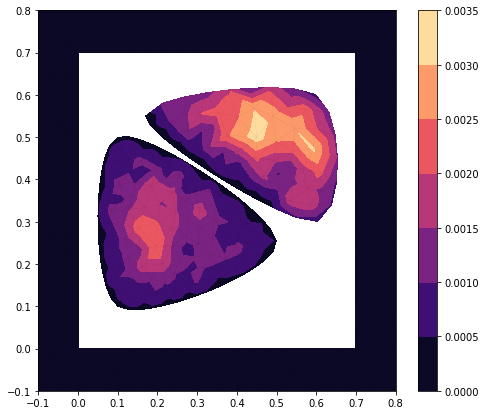

In [23]:
plot.plot_2d_diffusion_forcing_term_cg(mesh, u, f)

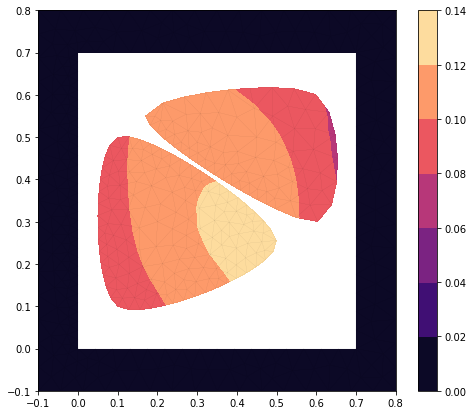

In [24]:
plot.plot_2d_diffusion_solution_cg(mesh, u, f)

# Summary

In [6]:
%matplotlib inline

import numpy as np
from scipy.sparse.linalg import spsolve
import nlfem
from mesh import trim_artificial_vertex
import plot
from conf import cfg_dict
import os
import matplotlib.pyplot as plt

In [7]:
cfg = cfg_dict["microelasticDG"]
vertices, elements, elementlabels = cfg["mesh"]
kernel = cfg["kernel"]
load = cfg["load"]
conf = cfg["conf"]

mesh, A = nlfem.stiffnessMatrix_fromArray(elements, elementlabels, vertices, kernel, conf)
slbl = mesh["solutionLabels"]

A_O = A[slbl > 0][:, slbl > 0]
A_D = A[slbl > 0][:, slbl < 0]

if conf["ansatz"] == "CG":
    dirichlet_Vdx = mesh["vertexLabels"] < 0
if conf["ansatz"] == "DG":
    dirichlet_Vdx = (mesh["elements"][mesh["elementLabels"] < 0]).ravel()
g = np.apply_along_axis(load["dirichlet"], 1, vertices[dirichlet_Vdx]).ravel()
                    
f = nlfem.loadVector(mesh, load, conf)
# Very discontinuous right hand side
f[slbl == 3] *= 1.e3
f[slbl == 2] *= -1.e3

f_tilde = f[slbl > 0] - A_D.dot(g)

u = np.zeros(mesh["K"])
u[slbl > 0] = spsolve(A_O, f_tilde)
u[slbl < 0] = g

mesh, u, f = trim_artificial_vertex(mesh, u, f)

### List of examples

In [24]:
_ = [print(name) for name in cfg_dict.keys()]

disjoint_av
disjoint_noav
hole_noav
hole_av
peridynamics
fractionalCG
fractionalDG
microelasticDG


### List of plotting functions

In [21]:
_ = [print(name) for name in plot.__dict__.keys() if name[:4] == "plot"]

plot_2d_peridynamics_cg
plot_2d_diffusion_elementlabels
plot_2d_diffusion_vertexlabels
plot_2d_diffusion_forcing_term_cg
plot_2d_diffusion_forcing_term_dg
plot_2d_diffusion_solution_cg
plot_2d_diffusion_solution_dg
plot_2d_diffusion_cg
plot_2d_diffusion_dg
plot_3d_peridynamics
plot_function_dict


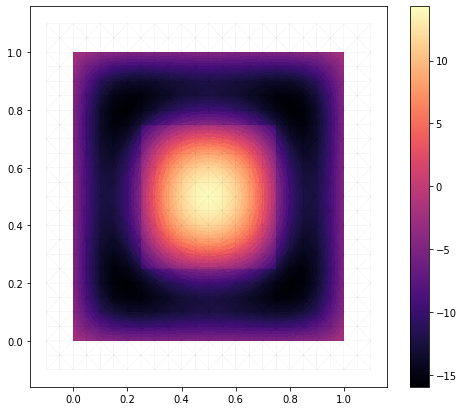

In [8]:
plot.plot_2d_diffusion_solution_dg(mesh, u, f, detailed=True)